In [1]:
import sys
sys.path.append('../')

In [2]:
import os
import glob
import fiona
import rasterio
import numpy as np
import rasterio.mask
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import utils
from tensorflow.keras import backend as K

 
import warnings
warnings.filterwarnings("ignore")

def conv_block(input_feature, filters, kernel_size=(1,1), strides=1, padding='same', use_relu=False):
    x = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding,
                                        kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')(input_feature)
    x = tf.keras.layers.BatchNormalization()(x)
    if use_relu:
        x = tf.keras.layers.Activation('relu')(x)
    return x

def depthwise_conv_block(input_feature, kernel_size, strides=1, padding='same', r=1):
    x = tf.keras.layers.DepthwiseConv2D(kernel_size=kernel_size, strides=strides, padding=padding, 
                                        dilation_rate=r, depthwise_initializer='he_normal',
                                        use_bias=True, bias_initializer='zeros')(input_feature)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x

def channel_attention_block(input_feature, ratio=8):
    channel = input_feature.shape[-1]

    shared_layer_one = tf.keras.layers.Dense(channel//ratio, activation='relu', kernel_initializer='he_normal',
                                            use_bias=True, bias_initializer='zeros')
    shared_layer_two = tf.keras.layers.Dense(channel, activation='relu', kernel_initializer='he_normal',
                                            use_bias=True, bias_initializer='zeros')
    
    avg_pool = tf.keras.layers.GlobalAveragePooling2D()(input_feature)
    avg_pool = tf.keras.layers.Reshape((1,1,channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = tf.keras.layers.GlobalMaxPooling2D()(input_feature)
    max_pool = tf.keras.layers.Reshape((1,1,channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    cbam_feature = tf.keras.layers.Add()([avg_pool,max_pool])
    cbam_feature = tf.keras.layers.Activation('sigmoid')(cbam_feature)
    return tf.keras.layers.multiply([input_feature, cbam_feature])

def spatial_attention_block(input_feature):
    kernel_size = 7
    channel = input_feature.shape[-1]
    cbam_feature = input_feature

    avg_pool = tf.keras.layers.Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    max_pool = tf.keras.layers.Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    concat = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])

    cbam_feature = tf.keras.layers.Conv2D(filters = 1, kernel_size=kernel_size, strides=1, padding='same',
                    activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(concat)

    return tf.keras.layers.multiply([input_feature, cbam_feature])

def cbam_block(cbam_feature, ratio=8):
    """Contains the implementation of Convolutional Block Attention Module(CBAM) block.
    As described in https://arxiv.org/abs/1807.06521.
    """

    cbam_feature = channel_attention_block(cbam_feature, ratio)
    cbam_feature = spatial_attention_block(cbam_feature)
    return cbam_feature

def ADM_block(input_feature):
    filters = input_feature.shape[-1]
    x = conv_block(input_feature, filters=filters, kernel_size=(1,1), strides=1, padding='same', use_relu=True)
    x = depthwise_conv_block(x, kernel_size=(3,3), strides=2, padding='same', r=1)
    x = conv_block(x, filters=filters, kernel_size=(1,1), strides=1, padding='same', use_relu=False)
    x_pool = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2)(input_feature)
    x_concat = tf.keras.layers.concatenate([x, x_pool], axis=-1)
    x = channel_attention_block(x_concat)
    x = tf.keras.layers.Activation('relu')(x)
    return x

def SCBAM_block(input_feature, r=1):
    filters = input_feature.shape[-1] // 4
    x = conv_block(input_feature, filters=filters, kernel_size=(1,1), strides=1, padding='same', use_relu=True)
    x = depthwise_conv_block(x, kernel_size=(3,3), strides=1, padding='same', r=r)
    x = conv_block(x, filters=filters*4, kernel_size=(1,1), strides=1, padding='same', use_relu=False)
    x = channel_attention_block(x)
    x_add = tf.keras.layers.Add()([x, input_feature])
    x = tf.keras.layers.Activation('relu')(x_add)
    return x

def stack_ADM_SCBAM(input_feature):
    x = ADM_block(input_feature)
    x = SCBAM_block(x)
    x = SCBAM_block(x)
    return x

def HDC_block(input_feature, rate_list):
    x = input_feature
    for i in rate_list:
        x = SCBAM_block(x, r=i)
    return x

def multi_HDC_block(input_feature, stage1=[1,2,5,9,1,2,5,9], stage2=[1,2,5,9], stage3=[1,2], stage4=[1]):
    x1 = HDC_block(input_feature, rate_list=stage1)
    x2 = HDC_block(x1, rate_list=stage2)
    x3 = HDC_block(x2, rate_list=stage3)
    x4 = HDC_block(x3, rate_list=stage4)
    x_concat = tf.keras.layers.concatenate([x1,x2,x3,x4,input_feature])
    return x_concat

def DUC_block(input_feature, out_channles=1, upscale=8):
    out_channles = out_channles * (upscale ** 2)
    x = tf.keras.layers.Conv2D(filters=out_channles, kernel_size=(1,1), strides=1, padding='same', use_bias=False)(input_feature)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    outputs = tf.nn.depth_to_space(x, upscale)
    return outputs

def MHA_Net(input_shape, filters=64, num_ADM_SCBAM=3):
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = conv_block(inputs, filters=filters, kernel_size=(3, 3))
    x = conv_block(x, filters=filters*2, kernel_size=(3, 3))

    for _ in range(num_ADM_SCBAM):   
        x = stack_ADM_SCBAM(x)

    x = multi_HDC_block(x)
    x = channel_attention_block(x)
    x = conv_block(x, filters=filters*16, kernel_size=(1,1))
    x = tf.keras.layers.Conv2D(filters=filters, kernel_size=(1,1), strides=1, padding='same',
                                kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')(x)
    x = DUC_block(x)
    x = tf.keras.layers.Activation('sigmoid')(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=x)
    return model

In [3]:
from preprocess.prepare_dataset import data_gen

out_path = '/home/quyet/DATA_ML/Projects/road_thailand/tmp'
overlap_mask = os.path.join(out_path, 'mask_cut_crop')
train_dataset, valid_dataset, _, _ = data_gen(os.path.join(overlap_mask, '*.tif'), img_size=256, 
                                                            batch_size=2, N_CLASSES=1, numband=3, 
                                                            split_ratios=0.8, test_data=False, multi=False)

2022-08-09 17:21:36.685633: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4971 MB memory:  -> device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:05:00.0, compute capability: 6.1


Training:validation = 924:232


In [4]:
from models import loss
from models.metrics import iou, dice_coef
from models.callback.save_best import SavebestweightsandEarlyStopping

model_name = 'mhanet'
mission = 'road_thailand'
img_size = 256
num_class = 1 
batch_size = 2

def lr_decay(epoch):
    initial_learningrate=1e-2
    if epoch < 1:
        return initial_learningrate
    else:
        return initial_learningrate * 0.9 ** (epoch)

if batch_size >1:
    val_batch_size = int(batch_size/2)
else:
    val_batch_size = batch_size
    
print("Init metric function")
if num_class==1:
    recall = tf.keras.metrics.Recall()
    precision = tf.keras.metrics.Precision()
    model_metrics = [precision,
                     recall, 
                     dice_coef,
                     iou, 
                     # tf.keras.metrics.BinaryAccuracy(threshold=0.5)
                    ]
else:
    recall = tf.keras.metrics.Recall()
    precision = tf.keras.metrics.Precision()
    accuracy = tf.keras.metrics.CategoricalAccuracy()
    model_metrics = [precision, recall, dice_coef, iou, accuracy]
    
checkpoint_filepath= '/home/quyet/DATA_ML/Projects/segmentation/logs/tmp'
log_dir = '/home/quyet/DATA_ML/Projects/segmentation/logs/graph'
weights_path = '/home/quyet/DATA_ML/WorkSpace/segmentation/weights/%s/'%(model_name) +model_name+'_'+mission+'_'+str(img_size)+'_'+str(num_class)+'class.h5'
patience = 10

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only= True, 
                                                                monitor='val_loss', mode='min', save_best_only=True)
model_lrscheduler_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=1)
model_lrreduce_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=patience, min_lr=1e-7, verbose=1)
model_earlystopping_callback = SavebestweightsandEarlyStopping(patience=patience, weights_path=weights_path)
model_endtrainnan_callback = tf.keras.callbacks.TerminateOnNaN()
model_tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=True)
model_callbacks = [model_checkpoint_callback, model_lrscheduler_callback,
                    model_lrreduce_callback, model_earlystopping_callback,
                    model_tensorboard_callback,]

model = MHA_Net((img_size,img_size,3))

optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer = optimizer, loss = loss.binary_focal_loss(gamma=2, alpha=.5),
             metrics = model_metrics
             )

# model.load_weights('/home/quyet/DATA_ML/WorkSpace/segmentation/weights/ffnet/ffnet_road_256_1class_val.h5')
history_train = model.fit(train_dataset, batch_size=batch_size, epochs=100, verbose=1, 
                      callbacks=model_callbacks, validation_data=valid_dataset, 
                      validation_batch_size=val_batch_size, use_multiprocessing=True)

Init metric function

Epoch 00001: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/100


2022-08-09 17:22:19.557521: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:812] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ingradient_tape/binary_focal_loss_fixed/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2022-08-09 17:22:31.823859: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100
2022-08-09 17:22:34.261548: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


    462/Unknown - 674s 1s/step - loss: 13.9154 - precision: 0.9490 - recall: 0.6893 - dice_coef: 0.7258 - iou: 0.5699
Save best train weights.
Save best val weights.


2022-08-09 17:36:05.433341: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 786432000 exceeds 10% of free system memory.
2022-08-09 17:36:07.172526: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 786432000 exceeds 10% of free system memory.
2022-08-09 17:36:09.197724: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1258291200 exceeds 10% of free system memory.


462/462 [==============================] - 863s 2s/step - loss: 13.9154 - precision: 0.9490 - recall: 0.6893 - dice_coef: 0.7258 - iou: 0.5699 - val_loss: 14.5214 - val_precision: 0.9578 - val_recall: 0.7277 - val_dice_coef: 0.7092 - val_iou: 0.5499 - lr: 1.0000e-04

Epoch 00002: LearningRateScheduler setting learning rate to 9e-05.
Epoch 2/100
462/462 [==============================] - ETA: 0s - loss: 11.9105 - precision: 0.9603 - recall: 0.7756 - dice_coef: 0.7424 - iou: 0.5905
Save best train weights.
Save best val weights.


2022-08-09 17:49:39.520459: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 786432000 exceeds 10% of free system memory.
2022-08-09 17:49:41.231199: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 786432000 exceeds 10% of free system memory.


462/462 [==============================] - 813s 2s/step - loss: 11.9105 - precision: 0.9603 - recall: 0.7756 - dice_coef: 0.7424 - iou: 0.5905 - val_loss: 9.9156 - val_precision: 0.9542 - val_recall: 0.8752 - val_dice_coef: 0.7709 - val_iou: 0.6277 - lr: 9.0000e-05

Epoch 00003: LearningRateScheduler setting learning rate to 8.1e-05.
Epoch 3/100
462/462 [==============================] - ETA: 0s - loss: 11.2333 - precision: 0.9622 - recall: 0.7963 - dice_coef: 0.7506 - iou: 0.6010
Save best train weights.
462/462 [==============================] - 797s 2s/step - loss: 11.2333 - precision: 0.9622 - recall: 0.7963 - dice_coef: 0.7506 - iou: 0.6010 - val_loss: 9.9693 - val_precision: 0.9648 - val_recall: 0.8424 - val_dice_coef: 0.7670 - val_iou: 0.6226 - lr: 8.1000e-05

Epoch 00004: LearningRateScheduler setting learning rate to 7.290000000000001e-05.
Epoch 4/100
462/462 [==============================] - ETA: 0s - loss: 10.7688 - precision: 0.9631 - recall: 0.8167 - dice_coef: 0.7563 - i

In [14]:
img = rasterio.open('/home/quyet/DATA_ML/Projects/road_thailand/tmp/img_cut_crop/07_Dec_Mosaic_P_2.tif_0_0007.tif').read()[:3]
img = img.swapaxes(0,1).swapaxes(1,2)
img = img[np.newaxis,...]
model.load_weights('/home/quyet/DATA_ML/WorkSpace/segmentation/weights/mhanet/mhanet_road_thailand_256_1class_train.h5')
mask = model.predict(img)

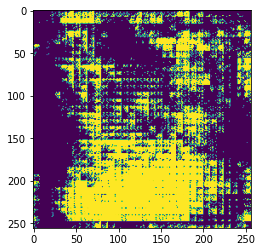

In [15]:
plt.imshow(mask[0])

In [9]:
import matplotlib.pyplot as plt